In [18]:
#!/usr/bin/env python3

import sys
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, concatenate
from keras_contrib.layers import CRF

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

def instances(fi):
    xseq = []
    yseq = []

    for line in fi:
        line = line.strip('\n')
        if not line:
            # An empty line means the end of a sentence.
            # Return accumulated sequences, and reinitialize.
            yield xseq, yseq
            xseq = []
            yseq = []
            continue

        # Split the line with TAB characters.
        fields = line.split('\t')

        # Append the item features to the item sequence.
        # fields are:  0=sid, 1=form, 2=span_start, 3=span_end, 4=tag, 5...N = features
        item = fields[5:]
        xseq.append(item)

        # Append the label to the label sequence.
        yseq.append(fields[4])
    #return xseq, yseq

def load_data(fi):
    xtrain = []
    ytrain = []

    for line in fi:
        line = line.strip('\n')
        if not line:
            continue
        # Split the line with TAB characters.
        fields = line.split('\t')

        # Append the item features to the item sequence.
        # fields are:  0=sid, 1=form, 2=span_start, 3=span_end, 4=tag, 5...N = features
        item = fields[5:]
        xtrain.append(item)

        # Append the label to the label sequence.
        ytrain.append(fields[4])
    return xtrain, ytrain



def instances_pred(fi):
    xseq = []
    toks = []
    for line in fi:
        line = line.strip('\n')
        if not line:
            # An empty line means the end of a sentence.
            # Return accumulated sequences, and reinitialize.
            yield xseq, toks
            xseq = []
            toks = []
            continue

        # Split the line with TAB characters.
        fields = line.split('\t')

        # Append the item features to the item sequence.
        # fields are:  0=sid, 1=form, 2=span_start, 3=span_end, 4=tag, 5...N = features
        item = fields[5:]
        xseq.append(item)

        # Append the label to the label sequence.
        toks.append([fields[0],fields[1],fields[2],fields[3]])
    #return xseq, toks

def load_glove():
    # load the whole embedding into memory
    embeddings_index = dict()
    f = open('../../../data/glove.6B/glove.6B.100d.txt')
    for line in f:
    	values = line.split()
    	word = values[0]
    	coefs = np.asarray(values[1:], dtype='float32')
    	embeddings_index[word] = coefs
    f.close()
    return embeddings_index


In [41]:
sentences = []
tags = []

fi = open('results/47/train.cod')


for xseq, yseq in instances(fi):
    sentences.append(xseq)
    tags.append(yseq)
fi.close()
fi = open('results/47/train.cod')
(xtrain, ytrain) = load_data(fi)
x = pd.DataFrame(xtrain)
y = pd.DataFrame(ytrain)[0].values

max_len = 75
words = list(set(x[0].values))
words.append("ENDPAD")
n_words = len(words)
utags = list(set(y))
n_tags = len(utags)

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(utags)}

docs = [[w[0] for w in s] for s in sentences]

In [42]:
len(sentences)

1301

In [45]:
#x
yt = pd.DataFrame(ytrain)
print(yt.count())
print(yt[yt[0] == 'O'].count())
print(yt[yt[0] == 'I-drug'].count())
print(yt[yt[0] == 'B-drug'].count())
print(yt[yt[0] == 'I-brand'].count())
print(yt[yt[0] == 'B-brand'].count())
print(yt[yt[0] == 'I-drug_n'].count())
print(yt[yt[0] == 'B-drug_n'].count())
print(yt[yt[0] == 'I-group'].count())
print(yt[yt[0] == 'B-group'].count())
print(utags)
print(yt.count())

0    29742
dtype: int64
0    27631
dtype: int64
0    92
dtype: int64
0    1160
dtype: int64
0    1
dtype: int64
0    13
dtype: int64
0    155
dtype: int64
0    373
dtype: int64
0    134
dtype: int64
0    183
dtype: int64
['O', 'I-drug', 'I-brand', 'B-brand', 'B-drug_n', 'B-drug', 'I-group', 'B-group', 'I-drug_n']
0    29742
dtype: int64


In [46]:
pos_tags = list(set(x[4].values))
pos_tags.append("ENDPAD")
n_pos = len(pos_tags)
pos2idx = {p: i + 1 for i, p in enumerate(pos_tags)}

X_pos = [[pos2idx[w[4]] for w in s] for s in sentences]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, padding="post", value=n_pos-1)

In [47]:
t = Tokenizer(oov_token='<unw>')
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(docs)
X = pad_sequences(maxlen=max_len, sequences=encoded_docs, padding="post", value=vocab_size-1)

embeddings_index = load_glove()
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


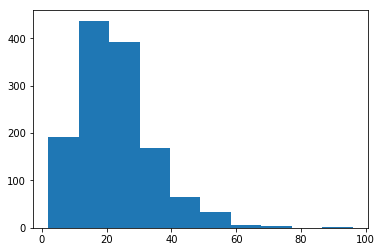

In [48]:
plt.hist([len(doc) for doc in docs])
plt.show()

In [5]:
tez = []
for seq in docs:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    tez.append(new_seq)



In [6]:
np.array(tez).shape

(5675, 75)

In [7]:
Y = [[tag2idx[t] for t in tag ]for tag in tags]


[[0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 7, 6, 0, 0, 0, 0],
 [0,
  0,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0,
  0,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [7, 0, 0, 0, 0, 0, 5, 0],
 [7, 6, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0],
 [0, 7, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 5, 0, 0, 7, 6, 0, 0, 0, 0],
 [7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  6,
  0,
  0,
  0,
  0,
  7,
  0,
  7,
  0,
  0,
  0,
  0,
  7,
  6,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [14]:
#Y = [[tag2idx[tag] for tag in y]]
Y = [[tag2idx[t] for t in tag ]for tag in tags]
#Y = pad_sequences(maxlen=max_len, sequences=Y, padding="post", value=tag2idx["O"])
#Y = [to_categorical(i, num_classes=n_tags) for i in Y]


In [16]:
np.array(Y).shape

(5675, 75)

In [17]:
[[t for t in tag] for tag in tags]

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-drug',
  'O',
  'O',
  'O',
  'O',
  'B-group',
  'I-group',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'B-drug',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-drug',
  'O',
  'B-drug',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'B-drug',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['B-group', 'O', 'O', 'O', 'O', 'O', 'B-drug', 'O'],
 ['B-group',
  'I-group',
  'O',
  'B-drug',
  'O',
  'O',
  'O',
  'B-drug',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-drug',
  'O',
  'O',
  'O'],
 ['O', 'B-group', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',


In [374]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
Y = np.array(Y)
for train_index, test_index in kf.split(X, np.array(Y)):
    train_x, val_x = X[train_index], X[test_index]
    train_y, val_y = Y[train_index], Y[test_index]

[[   5   93   28 ... 6707 6707 6707]
 [   5   44    4 ... 6707 6707 6707]
 [ 819    2   67 ... 6707 6707 6707]
 ...
 [ 134    2    7 ... 6707 6707 6707]
 [  79    2    5 ... 6707 6707 6707]
 [  63   34   13 ... 6707 6707 6707]] [[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]


In [ ]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=vocab_size, output_dim=100,
                  input_length=max_len, mask_zero=True, weights=[embedding_matrix],
                   trainable=False)(input)  # 20-dim embedding
#model = Embedding(input_dim=n_words + 1, output_dim=450,
#                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=32, return_sequences=True,
                           recurrent_dropout=0.5))(model)  # variational biLSTM
model = TimeDistributed(Dense(20, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model(input, out)

In [27]:
word_in = Input(shape=(max_len,))
word_emb = Embedding(input_dim=vocab_size, output_dim=100,
                  input_length=max_len, mask_zero=True, weights=[embedding_matrix],
                   trainable=False)(word_in)  # 20-dim embedding
#model = Embedding(input_dim=n_words + 1, output_dim=450,
#                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
pos_in = Input(shape=(max_len,))
pos_emb = Embedding(input_dim=n_pos, output_dim=100,
                    input_length=max_len, mask_zero=True)(pos_in)

concat = concatenate([word_emb, pos_emb])

model = Bidirectional(LSTM(units=32, return_sequences=True,
                           recurrent_dropout=0.5))(concat)  # variational biLSTM
model = TimeDistributed(Dense(20, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model([word_in, pos_in], out)

In [28]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 75)           0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 75)           0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 75, 100)      670800      input_11[0][0]                   
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 75, 100)      3600        input_12[0][0]                   
__________________________________________________________________________________________________
concatenat

In [29]:
X_pos

array([[13, 24, 21, ..., 35, 35, 35],
       [13,  1, 21, ..., 35, 35, 35],
       [21, 24, 25, ..., 35, 35, 35],
       ...,
       [13,  1, 33, ..., 35, 35, 35],
       [21,  1, 25, ..., 35, 35, 35],
       [ 8,  3, 34, ..., 35, 35, 35]], dtype=int32)

In [30]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

history = model.fit([X, X_pos], np.array(Y), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)
hist = pd.DataFrame(history.history)

/home/santiago/.local/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/home/santiago/.local/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.cast instead.
Train on 5107 samples, validate on 568 samples
Epoch 1/5
5107/5107 [==============================] - 19s 4ms/step - loss: 0.1886 - crf_viterbi_accuracy: 0.9617 - val_loss: 0.0628 - val_crf_viterbi_accuracy: 0.9787
Epoch 2/5
5107/5107 [==============================] - 17s 3ms/step - loss: 0.0488 - crf_viterbi_accuracy: 0.9842 - val_loss: 0.0415 - val_crf_viterbi_accuracy: 0.9865
Epoch 3/5
5107/5107 [==============================] - 18s 3ms/step - loss: 0.0363 - crf_viterbi_accuracy: 0.9882 - val_loss: 0.0330 - val_crf_viterbi_accuracy: 0.9893
Epoch 4/5
5107/5107 [==============================] - 17s 3ms/step - loss: 0.0304 - crf_viterbi_accuracy: 0.9899 - val_loss: 0.0287 - val_crf_viterbi_accuracy: 0.9905
Epoch 5/5
5107/5107 [==============================] - 18s 3ms/step - loss: 0.0267 - crf_viterbi_accuracy: 0.9912 - val_loss: 0.0270 - val_crf_viterbi_accuracy: 0.9913


In [145]:
hist

,val_loss,val_crf_viterbi_accuracy,loss,crf_viterbi_accuracy
0,0.258582,0.972,0.792232,0.897828
1,0.156056,0.972,0.239573,0.964419
2,0.133171,0.972,0.173716,0.964494
3,0.122984,0.972,0.156142,0.964494
4,0.114720,0.972,0.145783,0.964494


In [34]:
for xseq,toks in instances_pred(open('results/2/test.cod')):
    #x = pd.DataFrame(xseq)
    #x_test_sent = [[word2idx.get(t[0],0) for t in xseq]]
    docs = [[t[0] for t in xseq]]
    pos = [[pos2idx.get(t[4],0) for t in xseq]]
    encoded_docs = t.texts_to_sequences(docs)
    x_test_sent = pad_sequences(maxlen=max_len, sequences=encoded_docs, padding="post", value=vocab_size-1)
    x_test_pos = pad_sequences(maxlen=max_len, sequences=pos, padding="post", value=n_pos-1)
    #[[pos2idx[w[4]] for w in s] for s in sentences]

    prediction = model.predict([x_test_sent, x_test_pos])
    prediction_max = np.argmax(prediction[0], axis=-1)
    inside = False;
    for k in range(0,len(toks)) :
        y = utags[prediction_max[k]]
        (sid, form, offS, offE) = toks[k]
        
        if (y[0]=="B") :
            entity_form = form
            entity_start = offS
            entity_end = offE
            entity_type = y[2:]
            inside = True
        elif (y[0]=="I" and inside) :
            entity_form += " "+form
            entity_end = offE
        elif (y[0]=="O" and inside) :
            #print(sid, entity_start+"-"+entity_end, entity_form, entity_type, sep="|")
            print(sid + "|" + entity_start+"-"+entity_end + "|" +entity_form + "|" +entity_type + "\n")
            inside = False

    if inside : print(sid + "|" + entity_start+"-"+entity_end + "|" + entity_form + "|" + entity_type + "\n")

DDI-DrugBank.d660.s1|98-115|childhood vaccines|group

DDI-DrugBank.d660.s1|137-151|bronchodilators|group

DDI-DrugBank.d660.s1|156-170|corticosteroids|group

DDI-DrugBank.d621.s0|27-40|anticoagulants|group

DDI-DrugBank.d621.s1|26-35|colestipol|drug

DDI-DrugBank.d621.s1|38-51|cholestyramine|drug

DDI-DrugBank.d621.s1|71-80|sucralfate|drug

DDI-DrugBank.d672.s0|0-6|Digoxin|drug

DDI-DrugBank.d672.s0|9-20|Sparfloxacin|drug

DDI-DrugBank.d672.s0|63-69|digoxin|drug

DDI-DrugBank.d672.s1|0-14|Methylxanthines|group

DDI-DrugBank.d672.s1|17-28|Sparfloxacin|drug

DDI-DrugBank.d672.s1|55-66|theophylline|drug

DDI-DrugBank.d672.s2|35-46|theophylline|drug

DDI-DrugBank.d672.s2|72-86|methylxanthines|group

DDI-DrugBank.d672.s2|96-103|caffeine|drug

DDI-DrugBank.d672.s3|0-7|Warfarin|drug

DDI-DrugBank.d672.s3|10-21|Sparfloxacin|drug

DDI-DrugBank.d672.s3|70-77|warfarin|drug

DDI-DrugBank.d672.s4|0-9|Cimetidine|drug

DDI-DrugBank.d672.s4|12-21|Cimetidine|drug

DDI-DrugBank.d672.s4|63-74|sparfloxaci

DDI-DrugBank.d674.s1|129-138|paroxysmal|drug

DDI-DrugBank.d731.s0|96-102|RITUXAN|drug

DDI-DrugBank.d731.s1|68-76|cisplatin|drug

DDI-DrugBank.d657.s0|17-26|Dronabinol|drug

DDI-DrugBank.d657.s0|65-68|AIDS|drug

DDI-DrugBank.d657.s0|177-192|cytotoxic agents|group

DDI-DrugBank.d657.s0|195-215|anti-infective agents|group

DDI-DrugBank.d657.s0|218-226|sedatives|group

DDI-DrugBank.d657.s0|232-248|opioid analgesics|group

DDI-DrugBank.d657.s1|81-87|MARINOL|brand

DDI-DrugBank.d657.s1|99-110|cannabinoids|group

DDI-DrugBank.d657.s2|0-9|Dronabinol|drug

DDI-DrugBank.d657.s3|152-161|dronabinol|brand

DDI-DrugBank.d778.s0|47-56|BILTRICIDE|brand

DDI-DrugBank.d705.s0|0-10|Telbivudine|drug

DDI-DrugBank.d705.s0|34-50|passive diffusion|drug

DDI-DrugBank.d705.s0|94-104|telbivudine|drug

DDI-DrugBank.d705.s1|17-27|telbivudine|drug

DDI-DrugBank.d705.s1|96-106|telbivudine|brand

DDI-DrugBank.d705.s1|180-190|telbivudine|drug

DDI-DrugBank.d767.s1|20-38|vincristine sulfate|drug

DDI-DrugBank.d767.s

In [352]:
np.argmax(prediction[0], axis=-1).shape

(75,)

In [345]:
toks

[['DDI-DrugBank.d660.s0', 'No', '0', '1'],
 ['DDI-DrugBank.d660.s0', 'formal', '3', '8'],
 ['DDI-DrugBank.d660.s0', 'drug-drug', '10', '18'],
 ['DDI-DrugBank.d660.s0', 'interaction', '20', '30'],
 ['DDI-DrugBank.d660.s0', 'studies', '32', '38'],
 ['DDI-DrugBank.d660.s0', 'were', '40', '43'],
 ['DDI-DrugBank.d660.s0', 'conducted', '45', '53'],
 ['DDI-DrugBank.d660.s0', '.', '54', '54']]

In [226]:
pred_sentences = []
tokens = []
for xseq,toks in instances_pred(open('results/2/test.cod')):
    pred_sentences.append(xseq)
    tokens.append(toks)
#(xseq, toks) = instances_pred(open('results/2/test.cod'))
#x = pd.DataFrame(xseq)
#x_test_sent = [[word2idx.get(t[0],0) for t in xseq]]
docs = [[w[0] for w in s] for s in pred_sentences]
encoded_docs = t.texts_to_sequences(docs)
x_test_sent = pad_sequences(maxlen=max_len, sequences=encoded_docs, padding="post", value=vocab_size-1)

prediction = model.predict(x_test_sent)
prediction_max = np.argmax(prediction, axis=-1)
inside = False;
for k in range(len(tokens)) :
    y = utags[prediction[k]]
    (sid, form, offS, offE) = toks[k]

    if (y[0]=="B") :
        entity_form = form
        entity_start = offS
        entity_end = offE
        entity_type = y[2:]
        inside = True
    elif (y[0]=="I" and inside) :
        entity_form += " "+form
        entity_end = offE
    elif (y[0]=="O" and inside) :
        #print(sid, entity_start+"-"+entity_end, entity_form, entity_type, sep="|")
        print(sid + "|" + entity_start+"-"+entity_end + "|" +entity_form + "|" +entity_type + "\n")
        inside = False

    if inside : print(sid + "|" + entity_start+"-"+entity_end + "|" + entity_form + "|" + entity_type + "\n")

TypeError: only integer scalar arrays can be converted to a scalar index

In [236]:
docs

[['It',
  'is',
  'possible',
  'that',
  'concomitant',
  'use',
  'of',
  'other',
  'known',
  'photosensitizing',
  'agents',
  'might',
  'increase',
  'the',
  'photosensitivity',
  'reaction',
  'of',
  'actinic',
  'keratoses',
  'treated',
  'with',
  'methyl',
  'aminolevulinate',
  'cream',
  '.']]

In [230]:
x_test_sent

array([[ 165, 1015, 1015, ..., 1015, 1015, 1015],
       [  13, 1015, 1015, ..., 1015, 1015, 1015],
       [ 172, 1015, 1015, ..., 1015, 1015, 1015],
       ...,
       [   1, 1015, 1015, ..., 1015, 1015, 1015],
       [   1, 1015, 1015, ..., 1015, 1015, 1015],
       [1015, 1015, 1015, ..., 1015, 1015, 1015]], dtype=int32)

In [221]:
prediction[0][0]

array([1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [88]:
fi = open('results/47/test.cod')

sentences = []
for xseq, yseq in instances(fi):
    sentences.append(xseq)
    tags.append(yseq)
fi.close()

fi = open('results/47/test.cod')
(xtrain, ytrain) = load_data(fi)
x = pd.DataFrame(xtrain)
y = pd.DataFrame(ytrain)

In [112]:
y[y[0] == 'O'].count()

0    11441
dtype: int64

In [101]:
len(sentences)

520